In [184]:
import yaml
import numpy as np
import json

metadata = "D:\\Tina\\studying_ulm\\3 semester\\Autonomous driving\\PHAF\\camera_metadata.yaml"

def load_metadata(metadata_file):
    with open(metadata_file, 'r') as f:
        md = yaml.safe_load(f)
        #md = json.load(f)
    return md

def creatMatrix(camera):
    focal_length = meta[camera]['focal_length']
    resolution = meta[camera]['resolution']
    optical_center = meta[camera]['optical_center']
    alignment = meta[camera]['alignment']

    fx, fy = focal_length
    cx, cy = optical_center

    camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
    # dist_coef = np.zeros((5,))
    
    return camera_matrix, alignment

meta = load_metadata(metadata)

cameraMat_cent, al_cent = creatMatrix('camera_front_center')
cameraMat_right, al_right = creatMatrix('camera_front_right')
cameraMat_left, al_left = creatMatrix('camera_front_left')
cameraMat_back, al_back = creatMatrix('camera_rear_center')

In [185]:
def TimeStamp (file):
    with open(file, 'r') as f:
        ts = yaml.safe_load(f)
    return len(ts)

ts_center = 'D:\\Tina\\studying_ulm\\3 semester\\Autonomous driving\\PHAF\\_camera_front_center_image_rect_compressed_timestamps.yaml'

ts_c = TimeStamp(ts_center)
ts_c

970

In [186]:
# Provide the path to your video file
video_right = "D:\\Tina\\studying_ulm\\3 semester\\Autonomous driving\\PHAF\\_camera_front_right_image_rect_compressed.mp4"
video_left = "D:\\Tina\\studying_ulm\\3 semester\\Autonomous driving\\PHAF\\_camera_front_left_image_rect_compressed.mp4"
video_center = "D:\\Tina\\studying_ulm\\3 semester\\Autonomous driving\\PHAF\\_camera_front_center_image_rect_compressed.mp4"
video_back = "D:\\Tina\\studying_ulm\\3 semester\\Autonomous driving\\PHAF\\_camera_rear_center_image_rect_compressed.mp4"

In [268]:
## import cv2
import cv2 as cv
import cv2.aruco as aruco
from cv2 import aruco
import multiprocessing
import threading
import pandas as pd
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints


Distortion = np.zeros((5,))
share_points = []
shared_coord = []
means = []
non_empty_frames = []

def detect_aruco_markers(video_path, camera_matrix, distortion, position, alignment, barrier):
    
    # Initialize Kalman filter
    dt = 1
    
    # kalman_filter = KalmanFilter(dim_x=3, dim_z=3)

    # Set measurement function (H matrix)
    # kalman_filterH = np.eye(3)  # Identity matrix

    # Set state transition matrix (F matrix)
    # dt = 1 # Time step (adjust according to your frame rate)
    # kalman_filter.F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
    def f(x, dt):

        F = np.array([[1, dt, 0],
                      [0, 1, dt],
                      [0, 0, 1]])
        return np.dot(F, x)

# Observation function
    def h(x):
        
        H = np.array([[1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 1]])
        return np.dot(H, x)
    
    p = MerweScaledSigmaPoints(3, alpha=.01, beta=2., kappa=0)

    kalman_filter = UnscentedKalmanFilter(dim_x=1, dim_z=3, dt=1., fx=f, hx=h, points=p)
    
        # Set initial state
    kalman_filter.x = np.array([[0],[0],[0]])

    # Set measurement noise covariance matrix
    kalman_filter.R *= 1e-3 # np.eye(3)  # Identity matrix

    # Set process noise covariance matrix
    kalman_filter.Q *= 1e-9 # np.eye(3)  # Identity matrix

    kalman_filter.P *= 1e3
    
    coordinates = []
    ID_FirstPosition = dict()
    ID_RefPosition = dict()
    df = pd.DataFrame(columns=['Camera', 'ID', 'Frame detected', 'Reference position X', 'Reference position Y', 'Reference position Z'])
    index = 0
    count = 0
    init_position = [0, 0, 0]

    marker_lock = multiprocessing.Lock()
    cap = cv.VideoCapture(video_path)   
    
    aruco_dict = cv.aruco.getPredefinedDictionary(cv.aruco.DICT_4X4_50)
    parameters =  cv.aruco.DetectorParameters()
    detector = cv.aruco.ArucoDetector(aruco_dict, parameters)
    
    frame_num = 1
    marker_size = 0.18
    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)    

    while True:
        ret, frame = cap.read()   

        # if frame.empty():
        #     print('The frame is empty')

        if not ret:
            break

        # Convert the frame to grayscale
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # Detect ArUco markers     
        corners, ids, rejected = detector.detectMarkers(frame)
        
        trash = []
        rvecs = []
        tvecs = []
        
        # barrier.wait()
        # if len(shared_coord) == 3:
        #     mean_of_means = [np.mean([shared_coord[0][0], shared_coord[1][0], shared_coord[2][0]]),
        #                     np.mean([shared_coord[0][1], shared_coord[1][1], shared_coord[2][1]]),
        #                     np.mean([shared_coord[0][2], shared_coord[1][2], shared_coord[2][2]])]
            
            # means.append(mean_of_means)
            # shared_coord = []
            # print()
            # print('MEAN OF MEANS IS:', mean_of_means)
            # print()

        # Estimate pose of the camera
        if len(corners)> 0:
            count = count + 1
            i = 0
            for c in corners:
              t, R, extra = cv.solvePnP(marker_points, corners[i], camera_matrix,distortion, False)
              rvecs.append(R)
              extra = np.array(extra)
              extra = extra.transpose()
              tvecs.append(extra)
              i = i+1

            positions_per_frame = np.zeros((len(ids), 3))
            camera_position_homogeneous = np.array([0, 0, 0, 1]) # --> position of the camera in the world coordinate system
            frame_flag = 0
            TransformMat = np.eye(4)
            
            with marker_lock:

                print(position)
                print('Frame number:'+f'{frame_num}')
                for j in range(len(ids)):
                    
                    # frame = cv.drawFrameAxes(frame, camera_matrix, distortion, rvecs[j], tvecs[j], length=0.2)
                    RotMat, _ = cv.Rodrigues(rvecs[j])

                    TransformMat[:3,:3] = RotMat
                    #print(TransformMat[:3, 3])
                    TransformMat[:3, 3] = tvecs[j]
                    #print('transformMat',TransformMat)

                    ref_position = TransformMat*np.array(alignment) # --> rotation/translation matrix for the car
                    #print('ref_position',ref_position)
                    car_position_homogeneous = np.dot(ref_position, camera_position_homogeneous)  # --> position of the car in the world coordinate system
                    real_car_position = car_position_homogeneous[:3] / car_position_homogeneous[3] # --> convert back to Cartesian coordinates

                    
                    kalman_filter.predict()
                    kalman_filter.update(real_car_position.reshape(3, 1))
                    filt_position = kalman_filter.x
                    #print('real_car_position',real_car_position)

                    if len(ids) > 1:
                        idx = np.squeeze(ids)

                    else:
                        idx = ids.flatten()

                    if idx[j] not in ID_FirstPosition.keys(): #& idx[i] not in ID_RefPosition.keys():
                        first_position = filt_position
                        ID_FirstPosition.update({idx[j]:first_position})
                        # print('First position')
                        # print(f'{idx[i]}: {first_position}')
                        df.loc[index, ['Camera']] = position
                        df.loc[index, ['ID']] = idx[j]
                        df.loc[index, ['First frame detected']] = frame_num
                        index = index + 1
                    else:
                        if idx[j] not in ID_RefPosition.keys():
                            ref_position = filt_position - ID_FirstPosition[idx[j]]
                            ID_RefPosition.update({idx[j]:ref_position})
                            # df.loc[index, ['Camera']] = position
                            # df.loc[index, ['ID']] = idx[j]
                            df.loc[df.index[df['ID'] == idx[j]], ['Frame detected']] = frame_num
                            df.loc[df.index[df['ID'] == idx[j]], ['Reference position X', 'Reference position Y', 'Reference position Z']] = ref_position
                            # index = index + 1
                        else:
                            new_position = filt_position - ID_RefPosition[idx[j]]
                            # print('Estimated position')
                            print(f'{idx[j]}: {new_position}')
                            positions_per_frame[j,:] = new_position 

                positions_per_frame = positions_per_frame[~np.all(positions_per_frame == 0, axis=1)] 
                
                if len(positions_per_frame) > 0:
                    AvgPos_per_frame = np.mean(positions_per_frame, axis=0)
                else:
                    AvgPos_per_frame = np.full(3, np.nan)
        else:
            # kalman_filter.predict()
            AvgPos_per_frame = np.full(3, np.nan)
            # AvgPos_per_frame = kalman_filter.x
        
        coordinates = np.append(coordinates,AvgPos_per_frame, axis=0)
        
        shared_coord.append(AvgPos_per_frame)

        # barrier.wait()

        frame_num += 1

        barrier.wait()

        if frame_num == 968:
            print('POSITION:', position)
            break

        # Draw detected markers and show the frame
        frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
        # cv.imshow("ArUco Markers", frame_markers)
        # Exit if 'q' is pressed
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
            
    rows = len(coordinates)/3
    points = np.reshape(coordinates, (int(rows),3))
    share_points.append(points)
    non_empty_frames.append(count)

    # Release the video capture object and close windows
    cap.release()
    # cv2.destroyAllWindows()
    return df.sort_values('ID'), points

# Call the function to detect ArUco markers from the video
# df_right, p_right = detect_aruco_markers(video_right, cameraMat_right, Distortion, 'right',al_right, barrier=1) #388 --> for pre-processed
df_cent, p_cent = detect_aruco_markers(video_center, cameraMat_cent, Distortion, 'center',al_cent, barrier=1) # 571 --> for pre-processed, 703 --> for original
# df_left, p_left = detect_aruco_markers(video_left, cameraMat_left, Distortion, 'left',al_left, barrier=1)  # 760 --> for pre-processed
# df_back, p_back = detect_aruco_markers(video_back, cameraMat_back, Distortion, 'back', al_back, barrier=1) # 272 --> for pre-processed

center
Frame number:1


ValueError: could not broadcast input array from shape (3,1) into shape (3,)

In [220]:
def main():
    # Define the video paths and camera matrices for all videos
    video_paths = [video_center, video_left, video_right, video_back]
    Matrix = [cameraMat_cent, cameraMat_left, cameraMat_right, cameraMat_back]
    positions = ['center', 'left', 'right', 'rear']
    al = [al_cent, al_left, al_right, al_back]
    
    num_videos = len(video_paths)
    barrier = threading.Barrier(num_videos)
    
    processes = []

    for j, vid in enumerate(video_paths):
        p = threading.Thread(target=detect_aruco_markers, args=(video_paths[j], Matrix[j], Distortion, positions[j], al[j], barrier))
        p.start()
        processes.append(p)
        
        

    for p in processes:
        p.join()

if __name__ == "__main__":
    main()

Exception in thread Thread-38 (detect_aruco_markers):
Traceback (most recent call last):
  File "C:\Users\littl\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\littl\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\littl\AppData\Local\Temp\ipykernel_10620\1533993180.py", line 141, in detect_aruco_markers
  File "C:\Users\littl\AppData\Local\Programs\Python\Python310\lib\site-packages\filterpy\kalman\UKF.py", line 388, in predict
    self.compute_process_sigmas(dt, fx, **fx_args)
  File "C:\Users\littl\AppData\Local\Programs\Python\Python310\lib\site-packages\filterpy\kalman\UKF.py", line 503, in compute_process_sigmas
    self.sigmas_f[i] = fx(s, dt, **fx_args)
TypeError: 'numpy.ndarray' object is not callable


center
Frame number:1
left
Frame number:1


Exception in thread Thread-39 (detect_aruco_markers):
Traceback (most recent call last):
  File "C:\Users\littl\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\littl\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\littl\AppData\Local\Temp\ipykernel_10620\1533993180.py", line 141, in detect_aruco_markers
  File "C:\Users\littl\AppData\Local\Programs\Python\Python310\lib\site-packages\filterpy\kalman\UKF.py", line 388, in predict
    self.compute_process_sigmas(dt, fx, **fx_args)
  File "C:\Users\littl\AppData\Local\Programs\Python\Python310\lib\site-packages\filterpy\kalman\UKF.py", line 503, in compute_process_sigmas
    self.sigmas_f[i] = fx(s, dt, **fx_args)
TypeError: 'numpy.ndarray' object is not callable
Exception in thread Thread-40 (detect_aruco_markers):
Traceback (most recent call last):
  File "C:\Users\littl\AppD

right
Frame number:1
rear
Frame number:1


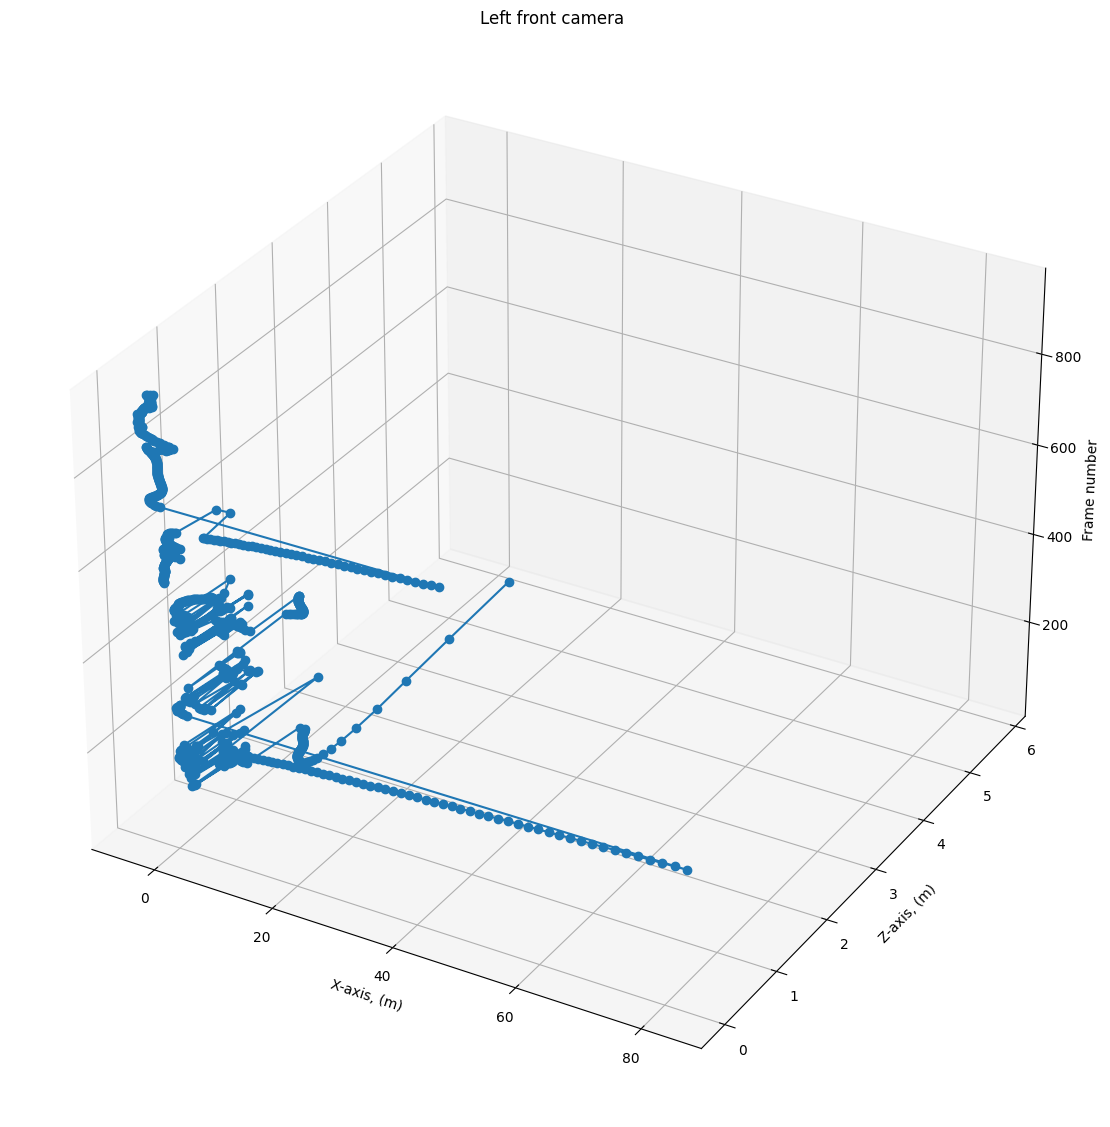

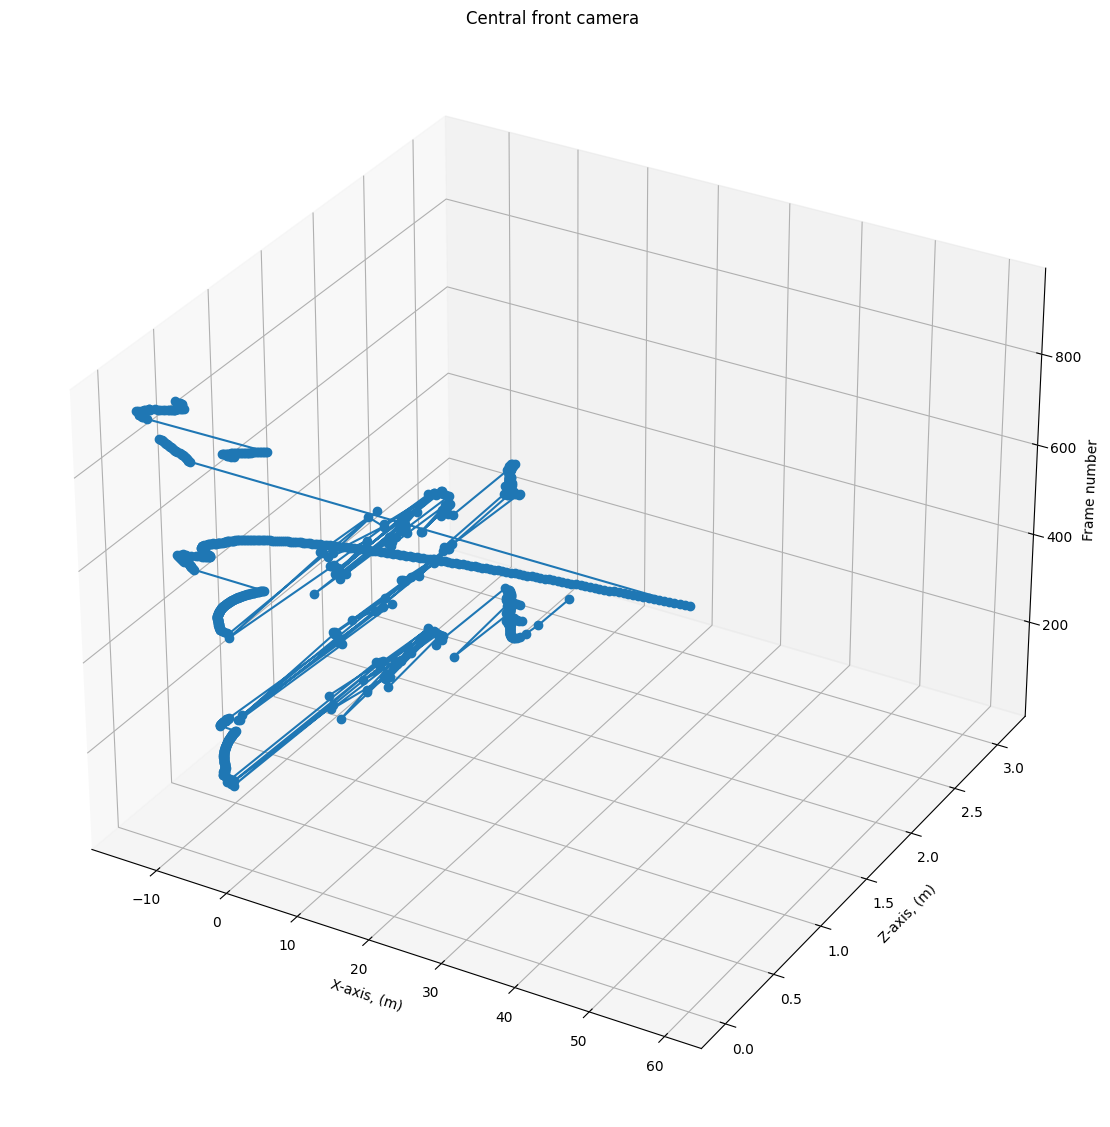

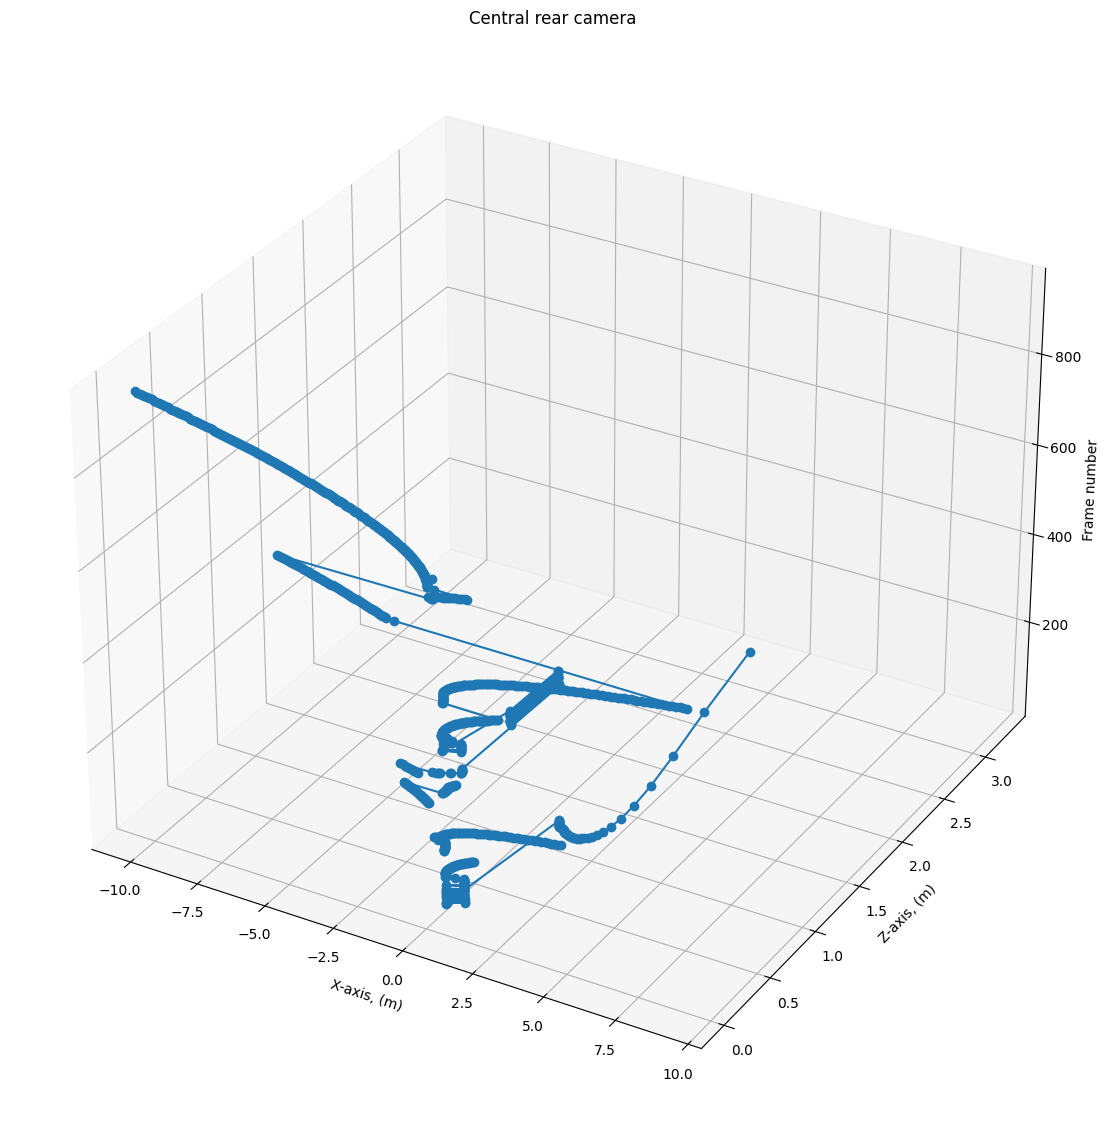

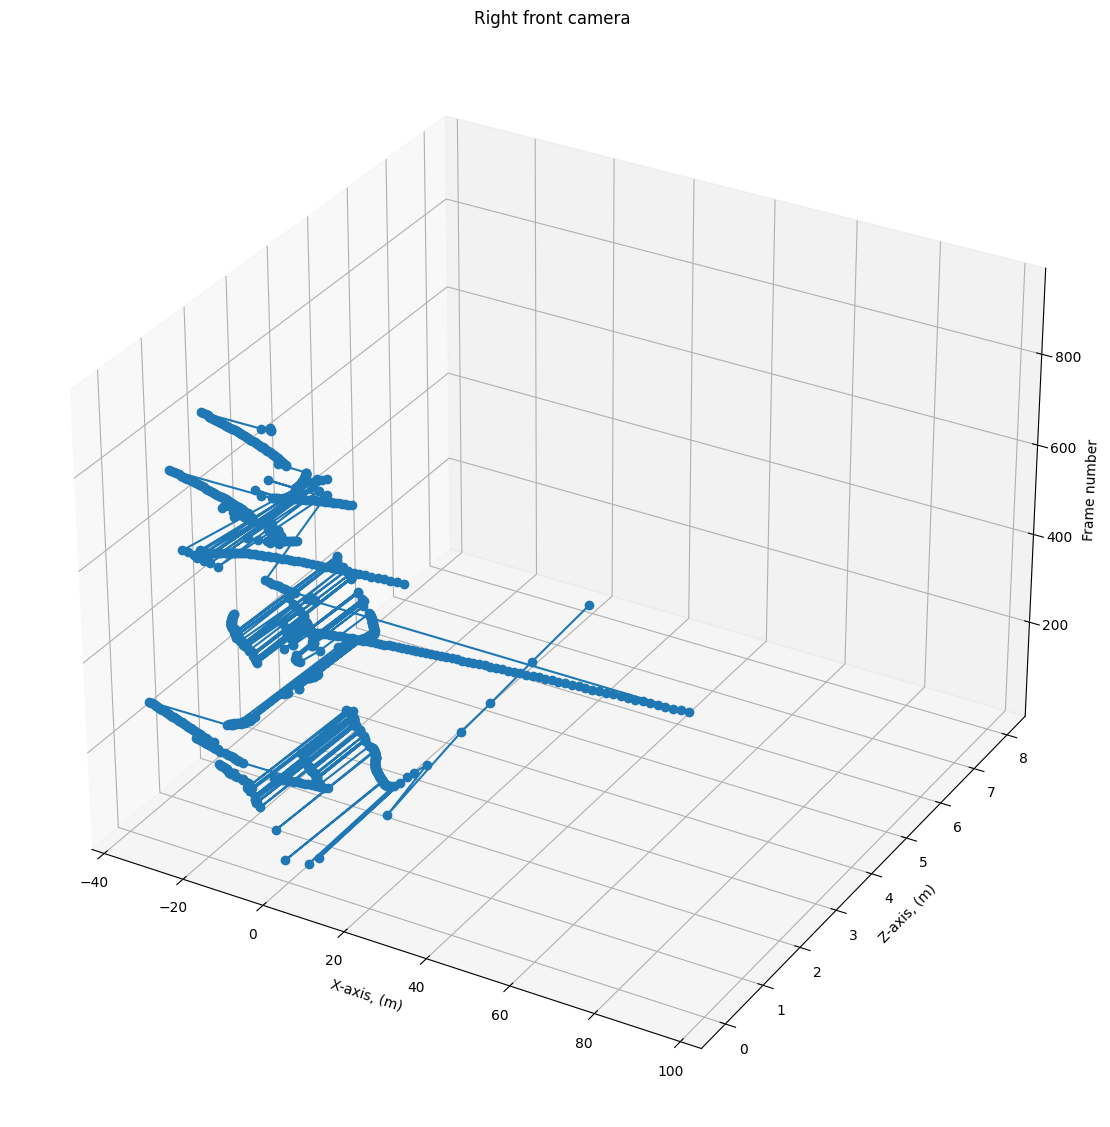

In [217]:
positions = ['Left front camera', 'Central front camera', 'Central rear camera', 'Right front camera']
# frames = list(range(0, 965))
# Plot all the 3D points together
# ax = fig.add_subplot(111, projection='3d')
for i, points in enumerate(share_points):
        frames = list(range(0, len(points)))
        fig = plt.figure(figsize=(14,18))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(points[2:, 0], points[2:, 2], frames[2:], marker='o')  #, points[2:, 1]*100
        # ax.view_init(elev=30, azim=-120)
        ax.set_title(positions[i])
        ax.set_xlabel('X-axis, (m)')
        # ax.set_ylabel('Y-axis, (m*10e-2)')
        ax.set_ylabel('Z-axis, (m)')
        ax.set_zlabel('Frame number')
        plt.savefig(positions[i]+'3D'+'.png')
    #plt.axis('equal')

# plt.show()

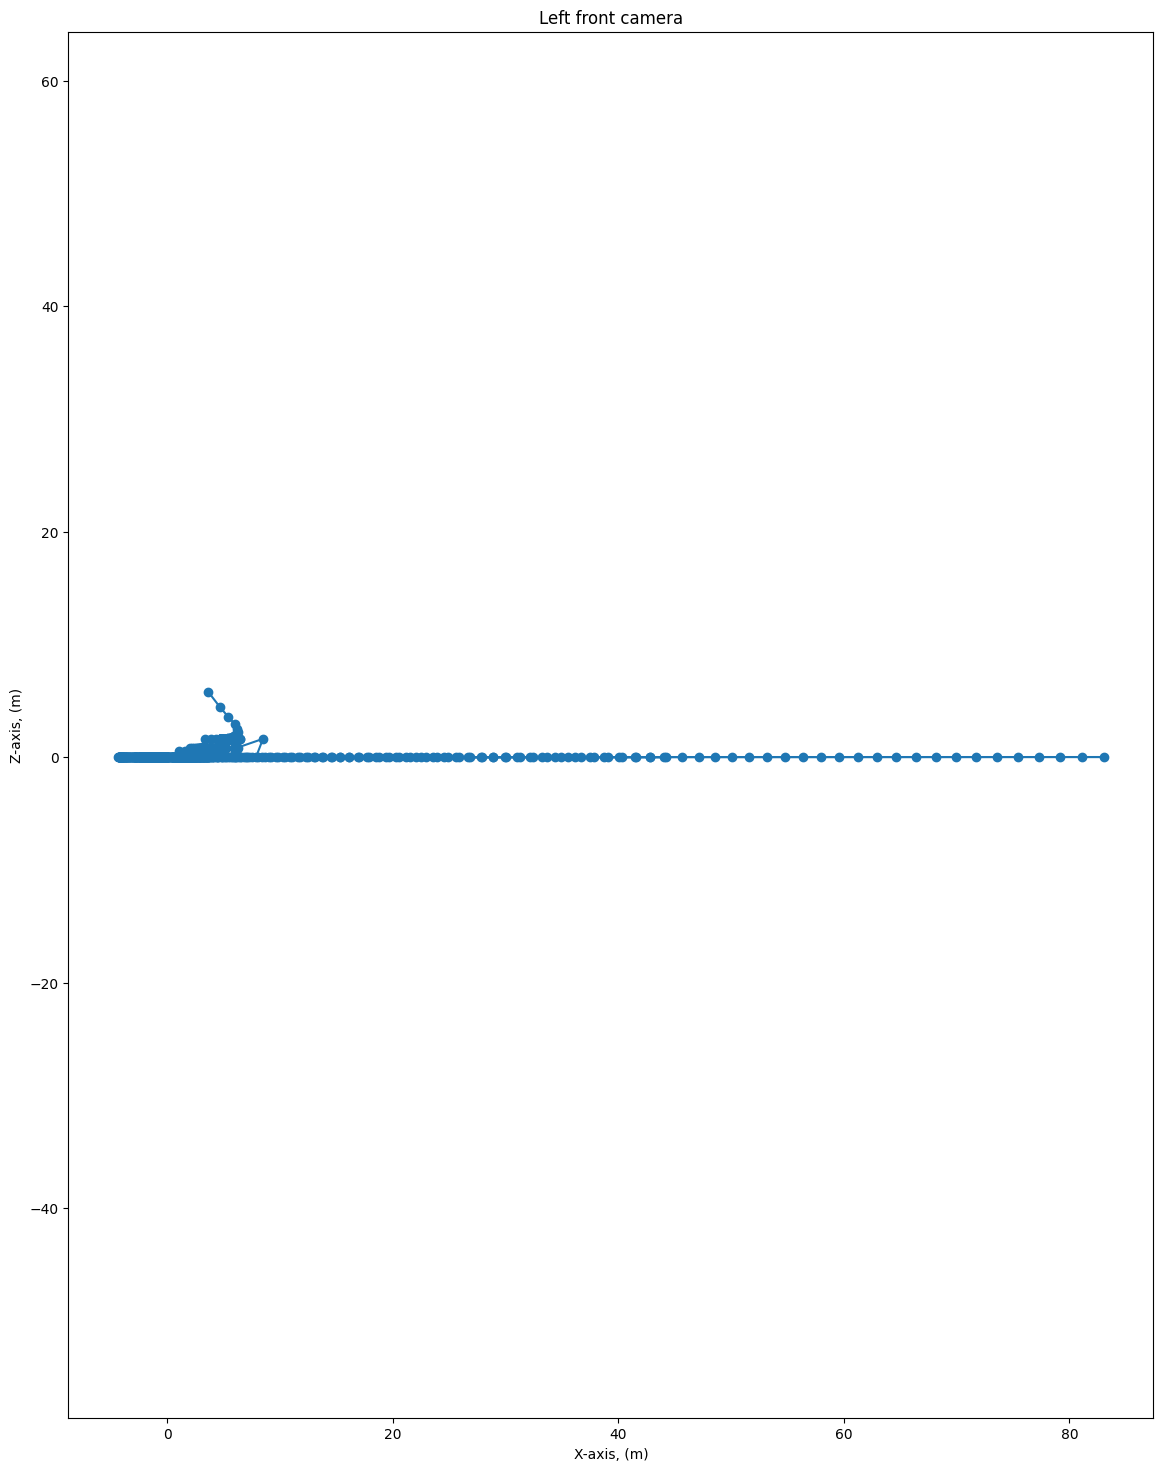

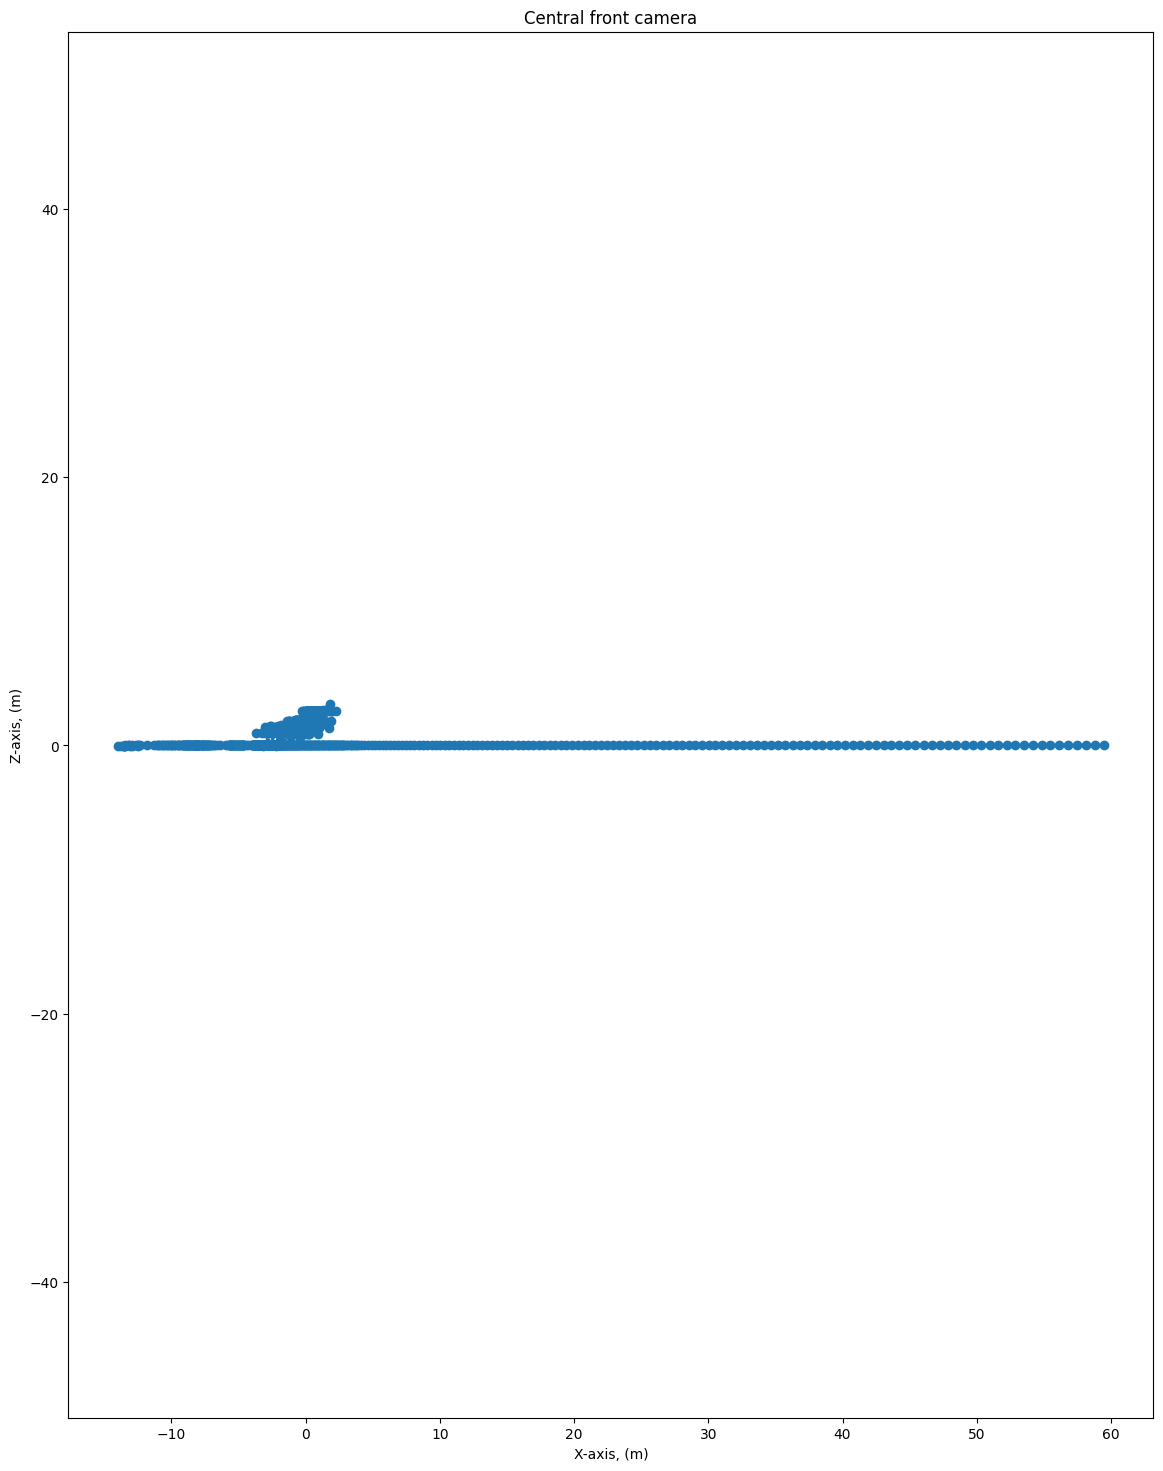

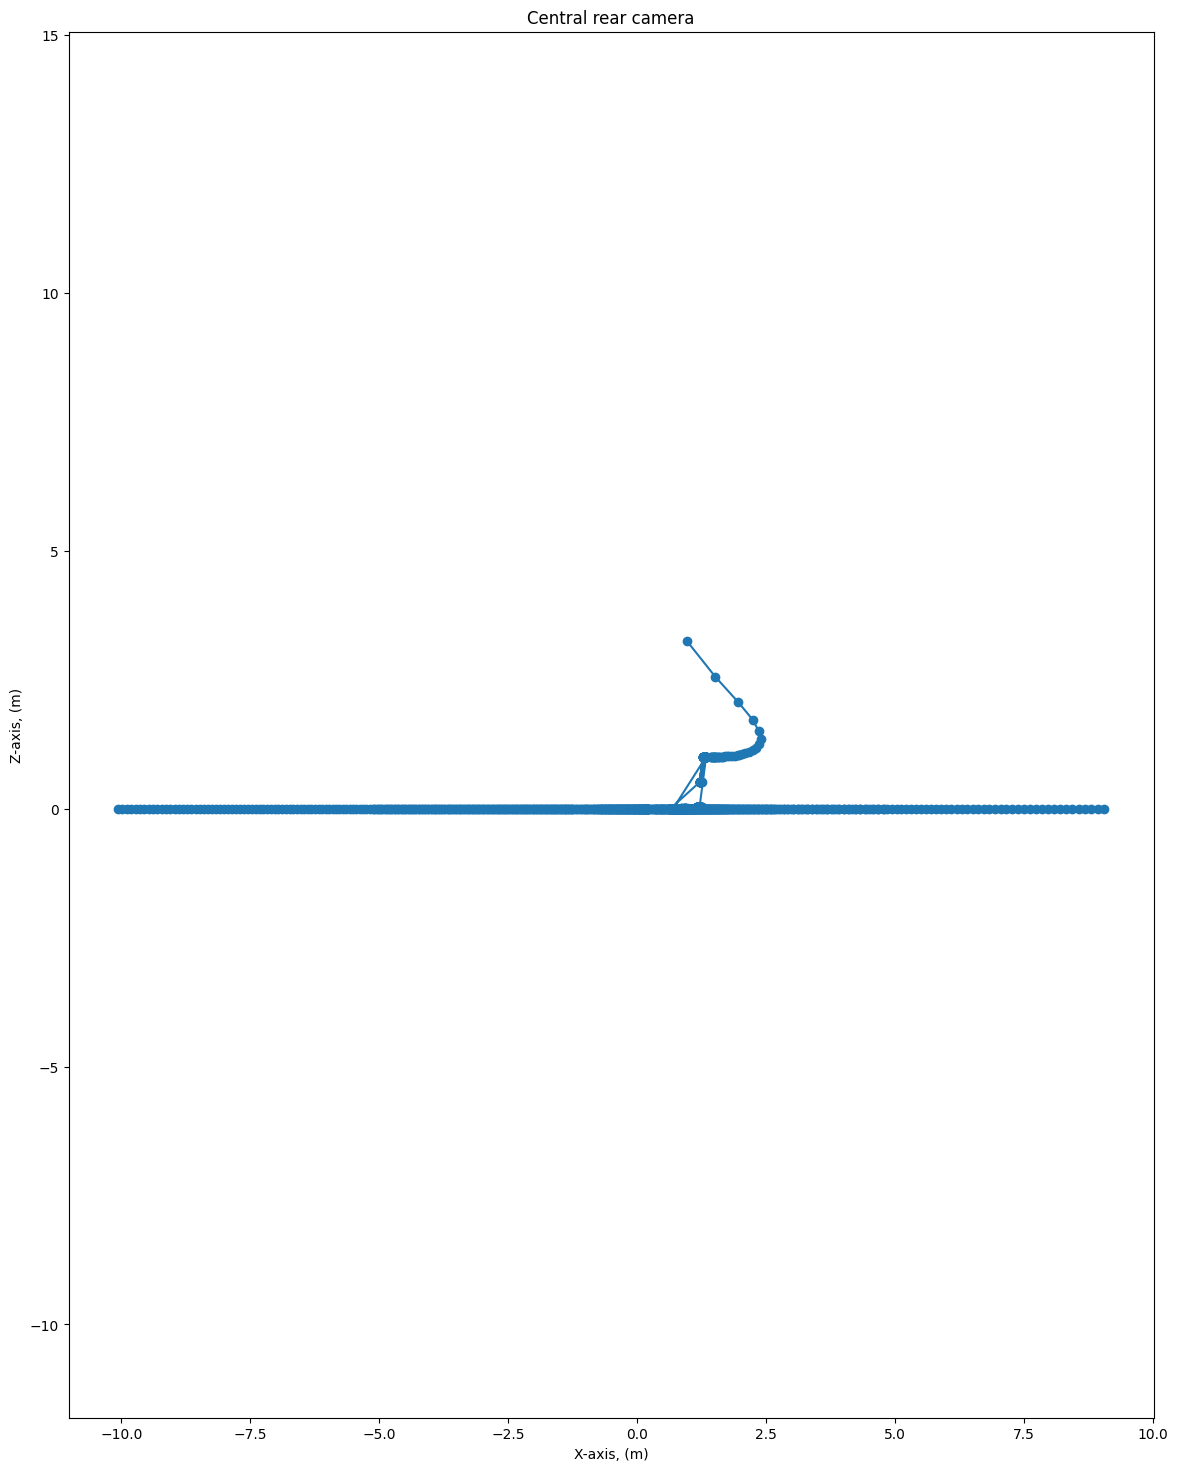

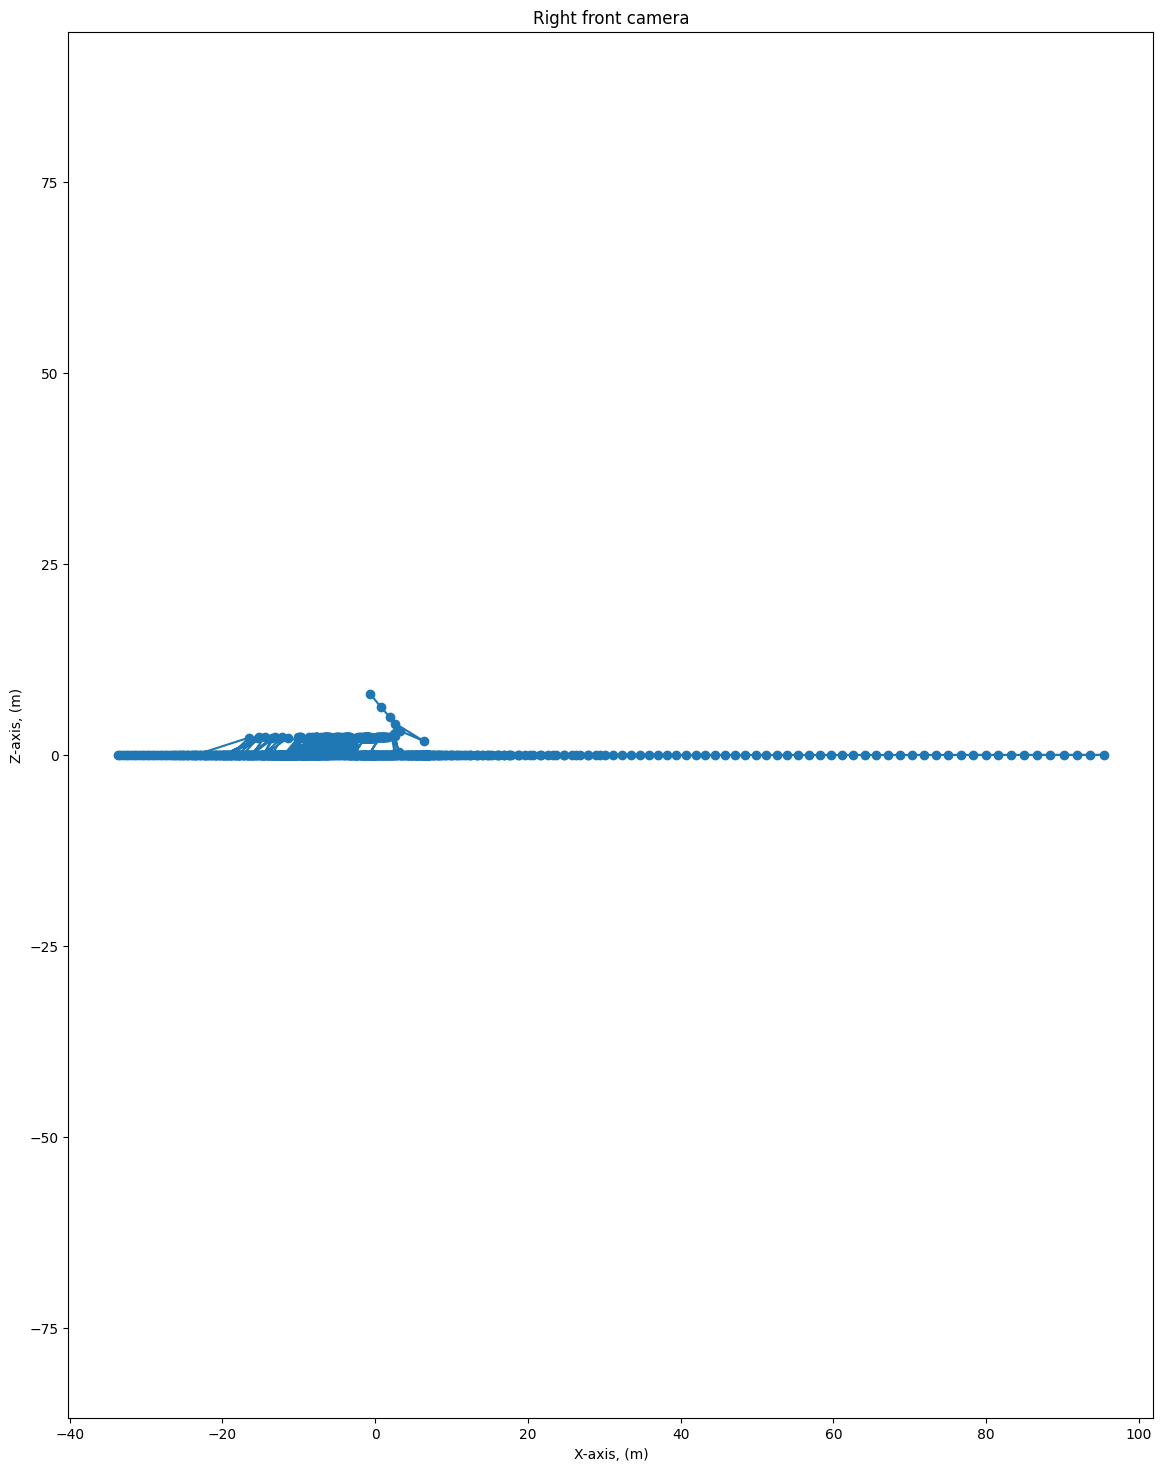

In [218]:
# positions = ['Central front camera', 'Central rear camera', 'Left front camera', 'Right front camera']

for i, points in enumerate(share_points):
    fig = plt.figure(figsize=(14,18))
    ax = fig.add_subplot(111)
    ax.plot(points[2:, 0], points[2:, 2], marker='o')  #, points[2:, 1]*100
    # ax.view_init(elev=30, azim=-120)
    ax.set_title(positions[i])
    ax.set_xlabel('X-axis, (m)')
    # ax.set_ylabel('Y-axis, (m*10e-2)')
    ax.set_ylabel('Z-axis, (m)')
    plt.savefig(positions[i]+'2D'+'.png')
    plt.axis('equal')

# plt.show()

<Figure size 640x480 with 0 Axes>

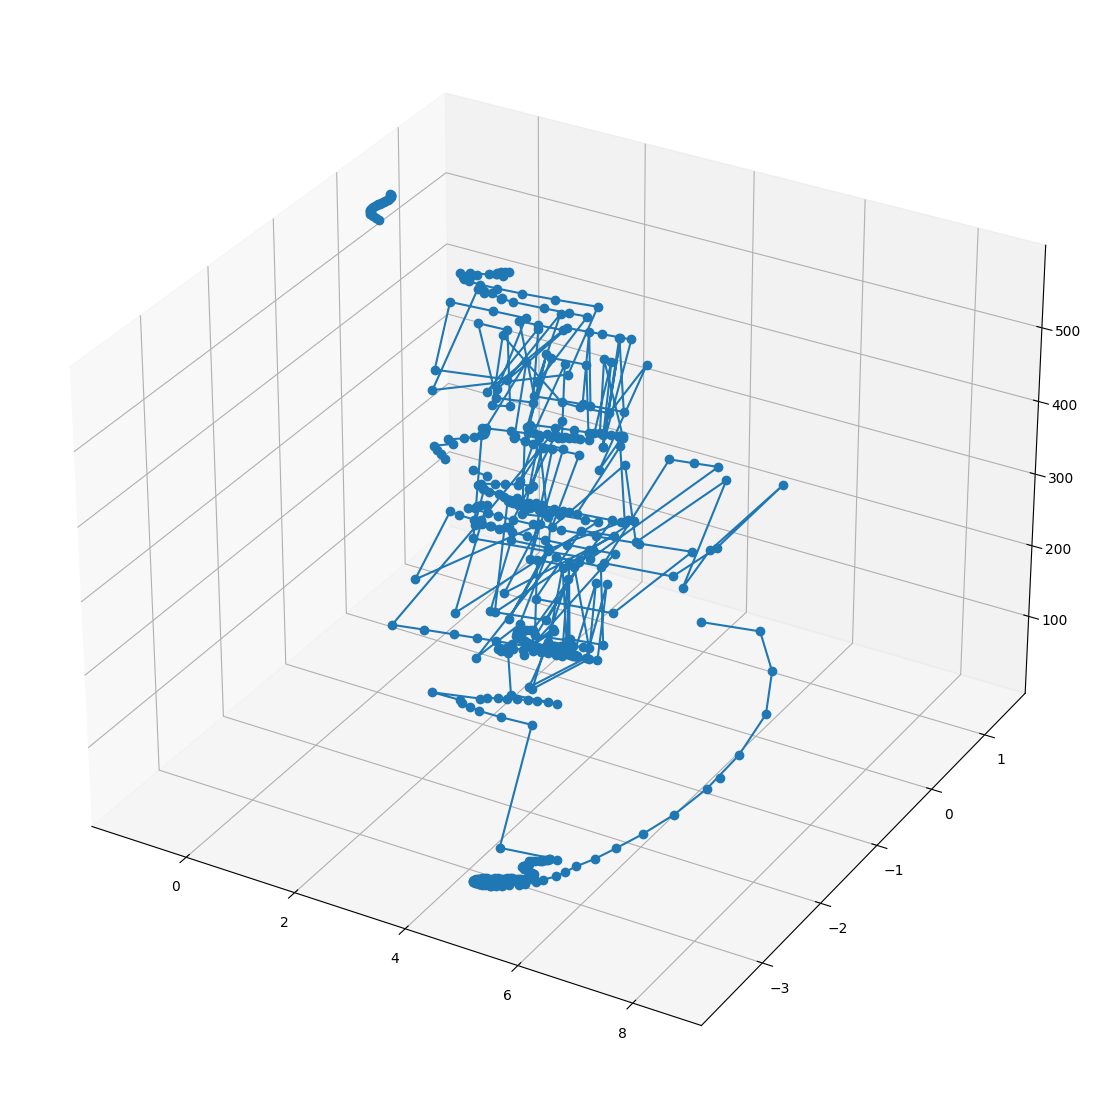

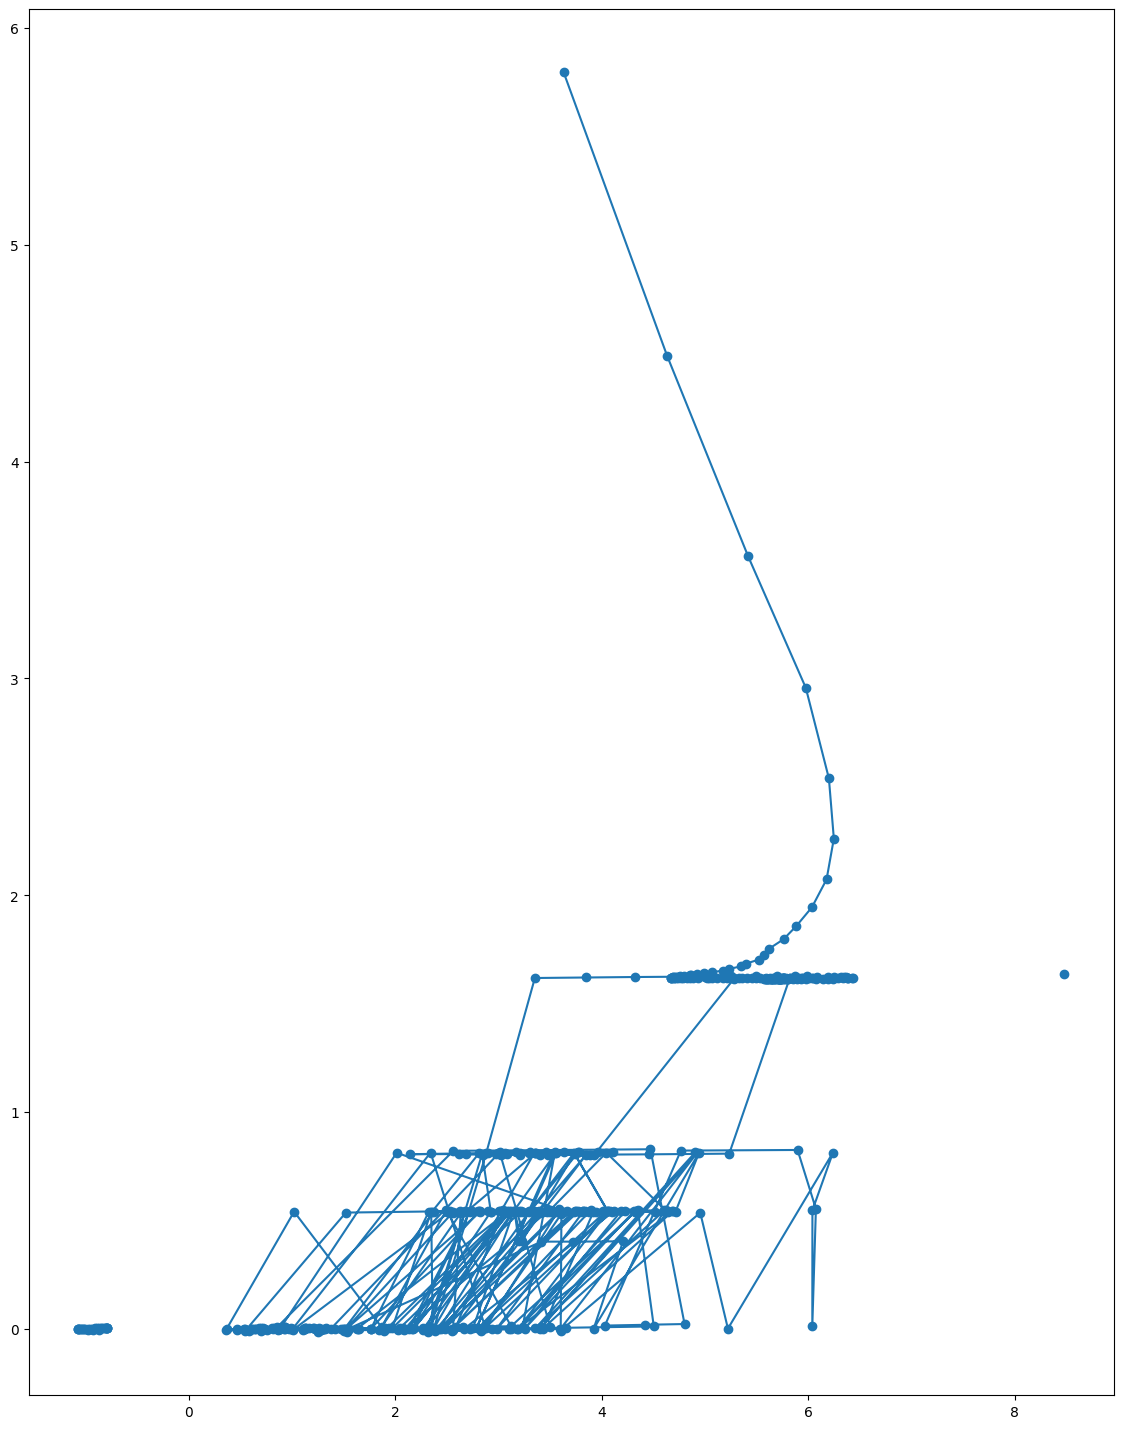

In [155]:
frames = list(range(0, len(p_left)))
plt.figure(1)
fig = plt.figure(figsize=(14,18))
ax = fig.add_subplot(111, projection='3d')
plt.plot(p_left[2:, 0], p_left[2:,1], frames[2:], marker='o')

plt.figure(2)
fig = plt.figure(figsize=(14,18))
plt.plot(p_left[2:, 0], p_left[2:, 2], marker='o')

In [79]:
df_cent

,Camera,ID,Frame detected,Reference position X,Reference position Y,Reference position Z
6,center,0,163,-1.326735,3.515913,4.771011
4,center,1,122,-2.186477,2.900031,4.056961
1,center,3,1,-0.725707,0.931267,3.810527
2,center,5,1,-0.134238,1.621284,4.000746
5,center,8,134,-2.946331,3.239541,4.703109
7,center,9,184,-3.329564,1.749486,2.81482
0,center,10,1,2.929584,0.787361,3.033563
3,center,17,53,7.842445,3.492783,6.856855


In [83]:
df_left

,Camera,ID,Frame detected,Reference position X,Reference position Y,Reference position Z
3,left,0,142,0.186943,2.696991,3.656345
1,left,1,103,1.072611,2.88895,4.436897
5,left,2,189,-0.265572,2.311843,3.935439
0,left,3,1,2.051964,0.840438,4.68247
2,left,8,120,-0.324501,2.158069,3.981491
4,left,9,167,-0.457756,1.928164,2.914298


In [258]:
def f(x, dt):

    F = np.array([[1, dt, 0],
                  [0, 1, dt],
                  [0, 0, 1]])
    return np.dot(F, x)

# Observation function
def h(x):

    H = np.array([[1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]])
    return np.dot(H, x)

p = MerweScaledSigmaPoints(3, alpha=.01, beta=2., kappa=0)

kalman_filter = UnscentedKalmanFilter(dim_x=3, dim_z=3, dt=1., fx=f, hx=h, points=p)

    # Set initial state
kalman_filter.x = (np.array([0,0,0])).transpose() # Initial position

# Set measurement noise covariance matrix
kalman_filter.R *= 1e-3 # np.eye(3)  # Identity matrix

# Set process noise covariance matrix
kalman_filter.Q *= 1e-9 # np.eye(3)  # Identity matrix

kalman_filter.P *= 1e3

In [259]:
kalman_filter

UnscentedKalmanFilter object
x = [0 0 0]
P = [[1000.    0.    0.]
     [   0. 1000.    0.]
     [   0.    0. 1000.]]
x_prior = [0. 0. 0.]
P_prior = [[1. 0. 0.]
           [0. 1. 0.]
           [0. 0. 1.]]
Q = [[1.e-09 0.e+00 0.e+00]
     [0.e+00 1.e-09 0.e+00]
     [0.e+00 0.e+00 1.e-09]]
R = [[0.001 0.    0.   ]
     [0.    0.001 0.   ]
     [0.    0.    0.001]]
S = [[0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]]
K = [[0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]]
y = [0. 0. 0.]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
sigmas_f = [[0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]]
h = [[0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]
     [0. 0. 0.]]
Wm = [-9998.99999999  1666.66666667  1666.66666667  1666.66666667
       1666.66666667  1666.66666667  1666.66666667]
Wc = [-9996.00009999  1666.66666667  

In [265]:
np.zeros([3,])

array([0., 0., 0.])